### Preprocessing Pipeline
1. Create a BIDSDataGrabber Node to read data files
2. Create a IdentityInterface Node to iterate over multiple Subjects
3. Create following Nodes for preprocessing: (Based on [Nan-kuei Chen's resting state analysis pipeline:](https://wiki.biac.duke.edu/biac:analysis:resting_pipeline)
    - [-] convert data to nii in LAS orientation (Skip if NYU is already in [LAS Orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm))
    - [x] Exclude 4 volumes from the functional scan 
    - [x] slice time correction
    - [x] motion correction, {[then regress out motion parameter] - This will be done later}
    - [x] Skull stripping and mask generation using mean of functional scan got using mcflirt
    - [x] Apply mask to Functional image
    - [x] Co-Registration with Anatomical Image
    - [x] normalize functional data
    - [-] regress out WM/CSF
    - [] bandpass filter
    
4. Embed them into a workflow
5. Do the Preprocessing of 3 subjects

In [342]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold,Info)
from nipype.interfaces.afni import Resample
from nipype.interfaces.io import DataSink
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
import os
from os.path import join as opj

In [343]:
# Paths

path_cwd = os.getcwd()
path_split_list = path_cwd.split('/')
s = path_split_list[0:-1]
s = opj('/',*s) # *s converts list to path, # very important to add '/' in the begining so it is read as directory later
base_directory = opj(s,'result') 
parent_wf_directory = 'preprocessPipeline'
child_wf_directory = 'coregistrationPipeline'

data_directory = opj(s,"data/ABIDE-BIDS/NYU/")

# mask_file = '/media/varun/LENOVO4/Projects/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/skullStrip/sub-0050952_T1w_resample_brain_mask.nii.gz'
# os.chdir(path)

In [344]:
base_directory

'/home/jovyan/work/preprocess/result'

In [345]:
number_of_subjects = 3 # Number of subjects you wish to preprocess

# base_directory = '/home/jovyan/work/preprocess/result'
# parent_wf_directory = 'preprocessPipeline'
# child_wf_directory = 'coregistrationPipeline'

In [346]:
layout = BIDSLayout(data_directory)

Checking the Data directory Structure

In [347]:
!tree /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/

/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/
├── participants.tsv
├── sub-0050952
│   ├── anat
│   │   └── sub-0050952_T1w.nii.gz
│   └── func
│       └── sub-0050952_task-rest_run-1_bold.nii.gz
├── sub-0050953
│   ├── anat
│   │   └── sub-0050953_T1w.nii.gz
│   └── func
│       └── sub-0050953_task-rest_run-1_bold.nii.gz
├── sub-0050954
│   ├── anat
│   │   └── sub-0050954_T1w.nii.gz
│   └── func
│       └── sub-0050954_task-rest_run-1_bold.nii.gz
├── sub-0050955
│   ├── anat
│   │   └── sub-0050955_T1w.nii.gz
│   └── func
│       └── sub-0050955_task-rest_run-1_bold.nii.gz
├── sub-0050956
│   ├── anat
│   │   └── sub-0050956_T1w.nii.gz
│   └── func
│       └── sub-0050956_task-rest_run-1_bold.nii.gz
├── sub-0050957
│   ├── anat
│   │   └── sub-0050957_T1w.nii.gz
│   └── func
│       └── sub-0050957_task-rest_run-1_bold.nii.gz
├── sub-0050958
│   ├── anat
│   │   └── sub-0050958_T1w.nii.gz
│   └── func
│       └── sub-0050958_task-rest_run-1_bold.nii.gz
├── sub-0050959
│   ├── an

In [348]:
layout.get_subjects(); # working!Gives us list of all the subjects

To get the metadata associated with a subject. [Takes as argumment the filename of subject ]

In [349]:
path_subject = opj(data_directory,'sub-0050954/func/sub-0050952_task-rest_run-1_bold.nii.gz')
metadata = layout.get_metadata(path=path_subject)

Let's extract the Repetition Time (of fMRI) of the subject whose metadata was extracted above

In [350]:
TR  = metadata['RepetitionTime']
metadata; # just add or remove the semicolon to supress or see the output

Lets look at a better way to extract the TR of an experiment of fMRI.  
In BIDS format there is one json file associated with the data set that contains the details of the data acquisition. Here we have -> ```task-rest_bold.json```. Let's extract the TR from this file.  
Similarly there is a json file associated with the anatomical scan as well. Here - ```T1w.json```

In [351]:
data_directory

'/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'

In [352]:
import json
json_path = opj(data_directory,'task-rest_bold.json')
with open(json_path, 'rt') as fp:
    task_info = json.load(fp)
#TR = task_info['RepetitionTime']
task_info;
# 'rt' means that you want to open the file in read mode and text mode(not sure what text mode is) 
# Also -> with open() as ... is just a fancy way of reading file that makes sure that the file object
# is destroyed automatically

Now you can extract the TR

In [353]:
TR = task_info['RepetitionTime']

Create a list of subjects

In [354]:
# number_of_subjects = 3

subject_list = (layout.get_subjects())[0:number_of_subjects]

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [355]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    anat_file_path = [f.filename for f in layout.get(subject=subject_id, type='T1w', extensions=['nii', 'nii.gz'])]
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return anat_file_path[0],func_file_path[0]

# Refer to Supplementary material section One for info on arguments for layout.get()

Wrap it inside a Node

In [356]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names=['anat_file_path','func_file_path']), name='BIDSDataGrabber')
BIDSDataGrabber.iterables = [('subject_id',subject_list)]
BIDSDataGrabber.inputs.data_dir = data_directory

In [357]:
#To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
# BIDSDataGrabber.inputs.subject_id = '0050954'
# res = BIDSDataGrabber.run()

# res.outputs


### Skipping 4 starting scans
Extract ROI for skipping first 4 scans of the functional data 
> **Arguments:**  
t_min: (corresponds to time dimension) Denotes the starting time of the inclusion  
t_size: Denotes the number of scans to include

The logic behind skipping 4 initial scans is to take scans after the subject has stabalized in the scanner.

In [358]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

### Slice time correction
Created a Node that does slice time correction
> **Arguments**:  
index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

In [359]:
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

In [360]:
# To test Slicetimer
# slicetimer.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res = slicetimer.run()
# res.outputs

### Motion Correction
Motion correction is done using fsl's mcflirt. It alligns all the volumes of a functional scan to each other

In [361]:
# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

In [362]:
# To test mcflirt
# mcflirt.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res_mcflirt = mcflirt.run()
# res_mcflirt.outputs

### Skull striping
I used fsl's BET

In [363]:
from nipype.interfaces.fsl import BET #,ExtractROI can be imported to ignore some brain volumes

In [364]:
skullStrip = Node(BET(mask=True),name='skullStrip') 

*Note*: Do not include special characters in ```name``` field above coz then  wf.writegraph will cause issues

In [365]:
# BET.help(); # Useful to see what are the parameters taken by BET

### Apply Mask to functional data
Mean file of the motion corrected functional scan is sent to skullStrip to get just the brain and the mask_image. Mask_image is just a binary file (containing 1 where brain is present and 0 where it isn't).    
After getting the mask_image form skullStrip, apply that mask to aligned functional image to extract its brain and remove the skull

In [366]:
# Function
# in_file: The file on which you want to apply mask
# mask_file:  The mask you want to use. Make sure that mask_file has same size as in_file
# out_file : Result of applying mask in in_file -> Gives the path of the output file

def applyMask_func(in_file, mask_file):
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj

    # convert from unicode to string : u'/tmp/tmp8daO2Q/..' -> '/tmp/tmp8daO2Q/..' i.e. removes the prefix 'u'
    mask_file = str(mask_file)

    brain_data = nib.load(in_file)
    mask_data = nib.load(mask_file)

    brain = brain_data.get_data()
    mask = mask_data.get_data()
    
    # applying mask by multiplying elementwise to the binary mask

    if len(brain.shape) == 3: # Anat file
        brain = np.multiply(brain,mask)
    elif len(brain.shape) > 3: # Functional File
        for t in range(brain.shape[-1]):
            brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)
    else:
        pass

    # Saving the brain file
    
#     # paths ------------------------------------- 
    path = os.getcwd()
#     print ("################# Current Working Directory is ################: ",path)
#     path_split_list = path.split('/')
#     s = path_split_list[0:-1]
#     s = opj(*s) # *s converts list to path
#     base_directory = opj(s,'result')
#     parent_wf_directory = 'preprocessPipeline'
#     child_wf_directory = 'coregistrationPipeline'
#     #---------------------------------------------
#     Not Needed. I found out that whenever a node is being executed, it becomes the current directory and whatever you create, will be stored here.
    
#     mask_file_split_list = mask_file.split('/')
#     mask_file_name = mask_file_split_list[-1]
    
    in_file_split_list = in_file.split('/')
    in_file_name = in_file_split_list[-1]
#     in_file_subject_name = in_file_split_list[-3]
    
#     from IPython.core.debugger import Tracer; Tracer()()    # Debugger doesnt work in nipype
#     print ("base_directory ",base_directory)
#     print ('parent_wf_directory ', parent_wf_directory)
#     print ('child_wf_directory ',child_wf_directory)
#     print ('in_file_subject_name ',in_file_subject_name )
#     print ('out_file ' ,out_file)
    
    out_file = in_file_name + '_brain.nii.gz' # changing name
    print ("The name of the file Outputted is ",out_file)
#     out_file = opj(base_directory, parent_wf_directory, child_wf_directory, in_file_subject_name, 'applyMask', out_file) # prefixing the saving location
    
    print ("The name of the final file path  outputted is ",out_file)
    brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
    nib.save(brain_with_header,out_file)
    
    out_file = opj(path,out_file)
    
    return out_file



In [367]:
# home/jovyan/work/preprocess/result/
# preprocessPipeline/coregistrationPipeline/
# _subject_id_0050952/result/preprocessPipeline/
# coregistrationPipeline/applyMask/
# sub-0050952_T1w_resample_brain_mask.nii.gz_brain.nii.gz'


In [368]:
# from os.path import join as opj
# opj(base_directory, parent_wf_folder, child_wf_folder, '_hekko.nii.gz')

Wrap the above function inside a Node

In [369]:
applyMask = Node(Function(function=applyMask_func, input_names=['in_file','mask_file'],
                                output_names=['out_file']), name='applyMask')

Create an IdentityInterface node to Distribute the subjects 

Create a list of subjects

Create an IdentityInterface Node that helps us to iterate over all the subjects. In this type of node the inputs = outputs that's why its called an identity node. It has an aditional feature that it can iterate over the values a single field can take. In our case we tell it to iterate over field '`subject_id`' and take values given by `subject_list`

In [370]:
# data_directory ->'/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'

In [371]:
# from nipype import IdentityInterface
# infosource = Node(IdentityInterface(fields=['subject_id','data_dir']),
#                   name="infosource")
# infosource.inputs.data_dir = data_directory 
# infosource.iterables = [('subject_id', subject_list)]
# # Note: Field 'data_dir' stays constant while the field'subject_id' takes on various values 
# #       as there are multiple subjects

In [372]:
# infosource.inputs

In [373]:
# infosource.outputs # Checking the outputs of the above created node

In [374]:
# Resample - resample anatomy to 2x2x2 voxel resolution
resample = Node(Resample(voxel_size=(2, 2, 2), resample_mode='Cu',
                         outputtype='NIFTI'),
                name="resample")

In [375]:
Resample.help()

Wraps command **3dresample**

Resample or reorient an image using AFNI 3dresample command

For complete details, see the `3dresample Documentation.
<https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dresample.html>`_

Examples

>>> from nipype.interfaces import afni
>>> resample = afni.Resample()
>>> resample.inputs.in_file = 'functional.nii'
>>> resample.inputs.orientation= 'RPI'
>>> resample.inputs.outputtype = 'NIFTI'
>>> resample.cmdline  # doctest: +ALLOW_UNICODE
'3dresample -orient RPI -prefix functional_resample.nii -inset functional.nii'
>>> res = resample.run()  # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file to 3dresample
		flag: -inset %s, position: -1

	[Optional]
	args: (a unicode string)
		Additional parameters to the command
		flag: %s
	environ: (a dictionary with keys which are a newbytes or None or a
		 newstr or None and with values which are a newbytes or None or a
		 newstr or None, nipype default value: {})
		Environment v

In [376]:
resample.outputs


out_file = <undefined>

In [377]:
# Create DataSink object
dataSink = Node(DataSink(), name='datasink')

# Name of the output folder
dataSink.inputs.base_directory = 'dataSink'



In [378]:
# Node for getting the xformation matrix 
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")

# Node for applying xformation matrix to functional data
coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")


# Node for Normalizing/Standardizing the anatomical and getting the xformation matrix
coreg_step1_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI'), name="coreg_step1_Normalize")

# Extra masking of 2mm anat file based on MNI mask coz it was a bit dialated
coreg_step1_Normalize_masking = Node(Function(function=applyMask_func, input_names=['in_file','mask_file'],
                                output_names=['out_file']), name="coreg_step1_Normalize_masking")


#Node for applying the xformation matirix to functional data

coreg_step2_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI', apply_xfm=True), name="coreg_step2_Normalize")


In [379]:
MNI152_2mm_mask = Node(IdentityInterface(fields=['mask_file']),
                  name="MNI152_2mm_mask")

MNI152_2mm_mask.inputs.mask_file = '/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

# MNI152_2mm_mask.run()

In [380]:
# MNI152_2mm_mask.outputs

I observed using fslsyes that the brain is enlarged if you Normalize a  brain resampled to 2mm brain. This in turn causes the functional data to enlarge as well after normalization. So, I will apply MNI152_2mm brain mask to the  resample brain after it has been normalized.

For that let's first create a Node that applies the  MNI152_2mm brain mast to the Output of Coreg_step1_Normalize. 

In [381]:
FLIRT.help()

Wraps command **flirt**

Use FSL FLIRT for coregistration.

For complete details, see the `FLIRT Documentation.
<http://www.fmrib.ox.ac.uk/fsl/flirt/index.html>`_

To print out the command line help, use:
    fsl.FLIRT().inputs_help()

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data
>>> flt = fsl.FLIRT(bins=640, cost_func='mutualinfo')
>>> flt.inputs.in_file = 'structural.nii'
>>> flt.inputs.reference = 'mni.nii'
>>> flt.inputs.output_type = "NIFTI_GZ"
>>> flt.cmdline # doctest: +ELLIPSIS +ALLOW_UNICODE
'flirt -in structural.nii -ref mni.nii -out structural_flirt.nii.gz -omat structural_flirt.mat -bins 640 -searchcost mutualinfo'
>>> res = flt.run() #doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		input file
		flag: -in %s, position: 0
	reference: (an existing file name)
		reference file
		flag: -ref %s, position: 1

	[Optional]
	angle_rep: (u'quaternion' or u'euler')
		representation of rotation angles
		fl

In [382]:
wf_coreg = Workflow(name="coregistrationPipeline")
wf_coreg.base_dir = "/home/jovyan/work/preprocess/result" # Dir where all the outputs will be stored(inside BETFlow folder).


wf_coreg.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]), # Sent the mean volume from mcflirt to coreg_step1
                  
            (BIDSDataGrabber,resample,[('anat_file_path','in_file')]), # Resampled the anat file to 2mm
            (resample,coreg_step1,[('out_file','reference')]), # Make the resampled file as reference in coreg_step1
            
            # Sec 1. The above 3 steps registers the mean image to resampled anat image and calculates the xformation matrix       
                  
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), # Motion corrected volumes (wrt mean-volume) given as input to coreg_step2  
            (resample,coreg_step2,[('out_file','reference')]), # Resampled 2mm anat used as reference to coreg_step2
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),# xformation matrix (mean->anat) is used to transform func volumes to resampled anat
            
            # Sec 2. The above 3 steps uses the xformation matrix computed in Sec 1. and trasforms the func volumes to resampled anat.        
          
            (resample, skullStrip, [('out_file','in_file')]), # resampled anat image is skull stripped and mask is generated
            (skullStrip, applyMask, [('mask_file','mask_file')]), # the mask is inputted in applyMask
            (coreg_step2, applyMask, [('out_file','in_file')]), # The functional image is inputted in applyMask
                  
            # Sec. 3. The above 3 Steps result is the skull stripping of func data based on mask got from anat
                  
                  
            (skullStrip, coreg_step1_Normalize, [('out_file','in_file')]), # gives the transformation matrix anat->MNI_2mm
            
            (coreg_step1_Normalize, coreg_step1_Normalize_masking, [('out_file','in_file')]), # masking again the Normalized anat image
            (MNI152_2mm_mask, coreg_step1_Normalize_masking, [('mask_file','mask_file')]), # using the mask from MNI152_2mm_mask 
            
             # Sec 4. Above 3 steps masks again the normalized anat and the next statement saves it to dataSink
                  
            (coreg_step1_Normalize_masking,dataSink,[('out_file','normalized_anat')]), # saving the normalized anatomical file of a subject
                 
#             # TODO: Now register the functional mean image to the above got normalized anat using coreg_step1
#                   # - Need to first create a xformation matrix with:
#                   #     - Reference as normalized anat got from - coreg_step1_Normalize_masking
#                   #     - in_file = func volume got from - applyMask
#                   #     - 
#             (coreg_step1_Normalize_masking, coreg_step1, [('out_file','reference')]),
#             (mcflirt->skullStrip, coreg_step1, [('out_file','in_file')]),    
                  
                  
                  
                  
            # Now, apply the matrix got using coreg_step1 to the functional     
            
                  
            (applyMask, coreg_step2_Normalize, [('out_file','in_file')] ), # Applies the transform to the functional file       
            (coreg_step1_Normalize, coreg_step2_Normalize, [('out_matrix_file','in_matrix_file')]),
                  
            (coreg_step2_Normalize, dataSink, [('out_file','normalized_func')]) # saving the normalized functional file of a subject     
           
            # The above steps transforms the functional to the MNI space using the xformation matrix (resampled_anat -> MNI)      
            ])



In [383]:
coreg_step2_Normalize.outputs


out_file = <undefined>
out_log = <undefined>
out_matrix_file = <undefined>

In [384]:
# opj(s,'result')

## Band Pass Filtering
Let's do a band pass filtering on the data using the code from http://nipype.readthedocs.io/en/latest/users/examples/rsfmri_vol_surface_preprocessing_nipy.html

In [385]:
def bandpass_filter(files, lowpass_freq, highpass_freq, fs):
    import numpy as np
    import os
    from nipype.utils.filemanip import (filename_to_list, split_filename,
                                        list_to_filename)
    """Bandpass filter the input files

    Parameters
    ----------
    files: list of 4d nifti files
    lowpass_freq: cutoff frequency for the low pass filter (in Hz)
    highpass_freq: cutoff frequency for the high pass filter (in Hz)
    fs: sampling rate (in Hz)
    """
    out_files = []
    for filename in filename_to_list(files):
        path, name, ext = split_filename(filename)
        out_file = os.path.join(os.getcwd(), name + '_bp' + ext)
        img = nb.load(filename, mmap=NUMPY_MMAP)
        timepoints = img.shape[-1]
        F = np.zeros((timepoints))
        lowidx = int(timepoints / 2) + 1
        if lowpass_freq > 0:
            lowidx = np.round(float(lowpass_freq) / fs * timepoints)
        highidx = 0
        if highpass_freq > 0:
            highidx = np.round(float(highpass_freq) / fs * timepoints)
        F[highidx:lowidx] = 1
        F = ((F + F[::-1]) > 0).astype(int)
        data = img.get_data()
        if np.all(F == 1):
            filtered_data = data
        else:
            filtered_data = np.real(np.fft.ifftn(np.fft.fftn(data) * F))
        img_out = nb.Nifti1Image(filtered_data, img.affine, img.header)
        img_out.to_filename(out_file)
        out_files.append(out_file)
    return list_to_filename(out_files)

### Let's Create a Node of the above function and try to execute it.

In [386]:
# bandpassFilter = Node()

In [387]:
# Create the workflow
# Refer to Supplementary material's Section Two for more on workspaces

wf = Workflow(name="preprocessPipeline")
base_dir = opj(s,'result')
wf.base_dir = base_dir # Dir where all the outputs will be stored(inside BETFlow folder).
# (infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),

wf.connect([      (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,wf_coreg,[('slice_time_corrected_file','mcflirt.in_file')]),
           ])
# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 8})

171001-16:55:55,473 workflow INFO:
	 Workflow preprocessPipeline settings: ['check', 'execution', 'logging']
171001-16:55:55,619 workflow INFO:
	 Running in parallel.
171001-16:55:55,654 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a0 ID: 0
171001-16:55:55,656 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a0 jobid: 0
171001-16:55:55,659 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a1 ID: 13
171001-16:55:55,662 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a1 jobid: 13
171001-16:55:55,664 workflow INFO:
	 Executing: BIDSDataGrabber.aI.a2 ID: 21
171001-16:55:55,666 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.aI.a2 jobid: 21
171001-16:55:55,670 workflow INFO:
	 Executing: resample.a0 ID: 1
171001-16:55:55,699 workflow INFO:
	 [Job finished] jobname: resample.a0 jobid: 1
171001-16:55:55,700 workflow INFO:
	 Executing: extract.a0 ID: 5
171001-16:55:55,705 workflow INFO:
	 [Job finished] jobname: extract.a0 jobid: 5
171001-16:55:55,707 workflow IN

TODO: Apply mni2mm mask on 2mm resampled anat brain and then  co-register the func on that 
    instead of unmasked 2mm anat brain
    coz 2mm brain is expanded and so the functional is expanded even more.

### Summary:

171001-16:55:56,421 workflow INFO:
	 Creating detailed dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph_detailed.dot
171001-16:55:57,914 workflow INFO:
	 Creating dot file: /home/jovyan/work/preprocess/result/preprocessPipeline/graph.dot


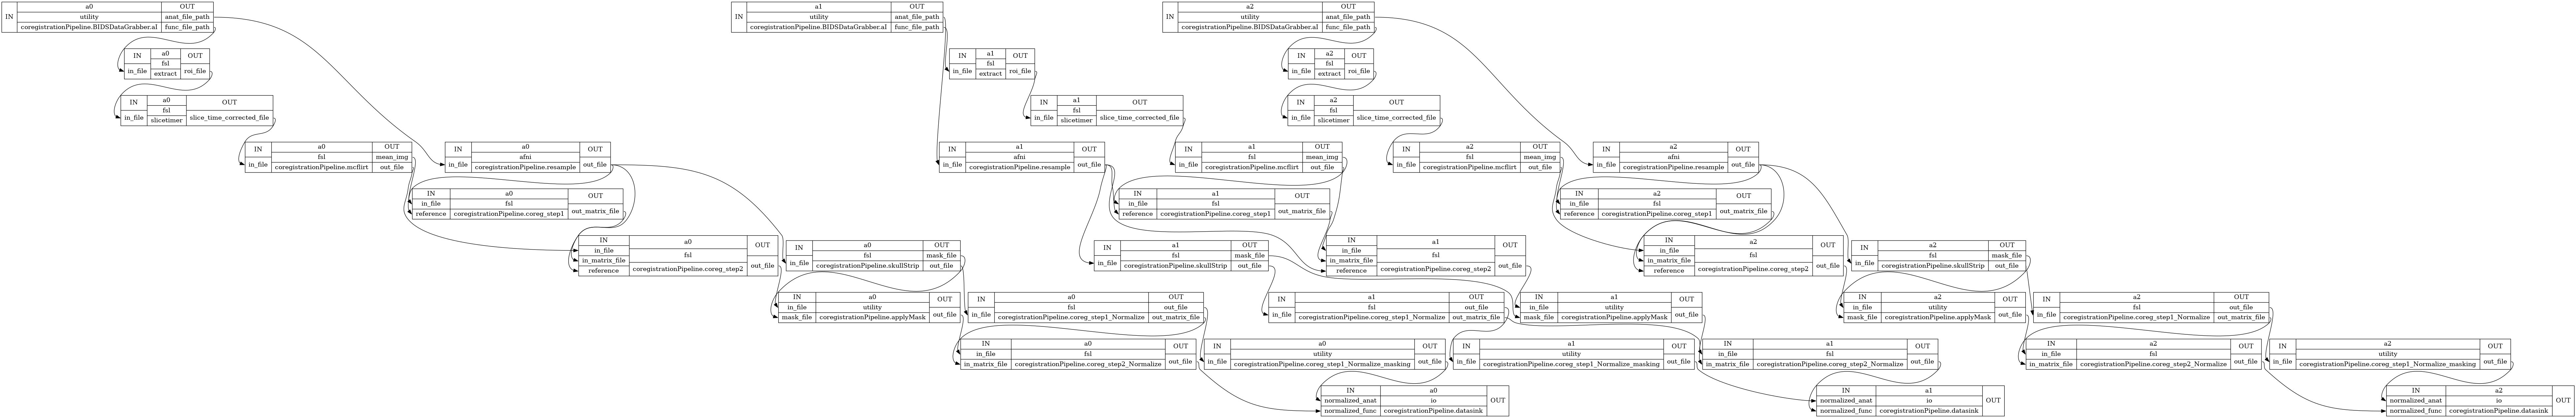

In [388]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)
file_name = opj(base_directory,'preprocessPipeline/graph_detailed.dot.png')
Image(filename=file_name)

### Summary [Incomplete]
```
wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','brain_file')]),
                  (skullStrip, applyMask, [('mask_file', 'mask_file')]), 
                  ])
```

In the above created workflow the `infosource` node iterates over the `subject_id`, it creates a Node and for each Subject ID it sends `data_dir` (path where the data resides) and the subject specific `subject_id` to `BIDSDataGrabber` Node.

`BIDSDataGrabber` Node accepts the above 2 parameters, calls the function `get_nifti_filenames(subject_id,data_dir)`which returns the path of the anatomical and BOLD files of the subject with given subject_id and hence the Node produces output that I call `func_file_path` and `anat_file_path`. I have used only `func_file_path`right now.

The file path denoted by '``func_file_path``' is then fed as input to `extract` that removes 4 initial brain volumes of the functional scan.

Its output is called - `slice_time_corrected_file` which is fed to `mcflirt` node to correct the movion between volumes of an individual subject. This is called **Motion Correction**.

In next step the mean_image from `mcflirt` is sent to `skullStrip` to get the mask. The role of `skullStrip` is just to obtain mask from the mean EPI image.

The mask got above is then applied to the functional volume to get rif of skull.



The final results are stored in the directory : `/home/jovyan/work/preprocess/result/BETFlow`. Every node has its own folder where its results are stored.




## Utility Functions

In [389]:
# To load and save a brain image to a convenient location so that I can view it in fslview
import nibabel as nib

def load_and_save(filepath, name):
    brain_data = nib.load(filepath)
#     brain_tensor = brain_data.get_data()

    print "Saving the brain file with name: ", name
    # brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
    nib.save(brain_data, name)

In [390]:
# load_and_save(str(res.outputs.slice_time_corrected_file), 'slicetimecorrectedfile_50954)

In [391]:
# MCFLIRT.help()
# To Stop execution Raise error:
raise Exception('Execution stops here!')

Exception: Execution stops here!

# Supplementary Material

# One

>### Arguments for  extracting relevent files
Anatomical files:  
filename='..._T1w.nii.gz', type='T1w', modality='anat', subject='0050952'

>Functional files:  
filename='..._bold.nii.gz',type='bold', task='rest', run='1', modality='func', subject='0050952'

In [ ]:
# By typing 
layout.get()
# I get all the filenames with their parameters that I can use to extract the relevent files.


# Two
>## Constructing a workflow  
To make a workflow you need the input and output names of the Nodes.  
- > **Example workflow**:  
```wf.connect([(<Source_Node>, <Destination_Node>, [('<output_from_source_node>','<input_to_destination_node>')])```
- To get the name of input for a Node type ```<Node_Name>.inputs```  
- To get the name of output of a Node write ```<Node_Name>.outputs```

In [ ]:
# for example, to get the the input info of ExtractROI Node type:
extract.inputs

In [ ]:
# to get the the input info of ExtractROI Node type:
extract.outputs

In [ ]:
skullStrip.outputs

# Dump

In [ ]:


# #Lets move ahead with creating more Nodes for preprocessing.  

# #Extract ROI for skipping first 4 scans of the functional data 

# # ExtractROI - skip dummy scans
# extract = Node(ExtractROI(t_min=4, t_size=-1),
#                output_type='NIFTI',
#                name="extract")

# #Do motion correction. So as to ensure that for a subject each brain volume is 'insync' with the other volume.

# # MCFLIRT - motion correction
# mcflirt = Node(MCFLIRT(mean_vol=True,
#                        save_plots=True,
#                        output_type='NIFTI'),
#                name="mcflirt")

# # To test mcflirt
# mcflirt.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# res_mcflirt = mcflirt.run()
# res_mcflirt.outputs

# ### To Visulize the output of mcflirt
# 1. Displayed in notebook only one volume using nilearn
# 2. Plotted histogram of original and corrected files
# 3. Saved copies of original and corrected files using nibabel to see in fslview

# from nilearn import image

# brain = image.load_img('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
# brain_MC = image.load_img('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')


# tenth_brain = image.index_img(brain, 30)
# tenth_brain_MC = image.index_img(brain_MC, 30)


# %pylab inline
# from nilearn.plotting import plot_anat
# plot_anat(tenth_brain, title='Original',
#           display_mode='ortho', dim=-1, draw_cross=False, annotate=False)


# from nilearn.plotting import plot_anat
# plot_anat(tenth_brain_MC, title='Motion Corrected',
#           display_mode='ortho', dim=-1, draw_cross=False, annotate=False)

# #The output as well as input looked washed out. So checked the intensity values of the brain

# import numpy as np
# import nibabel as nib

# brain_original = nib.load('/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz')
# brain_MC = nib.load('/tmp/tmpZG2rZL/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii')

# # checked max and min values of original brain
# np.max(brain_original.get_data()),np.min(brain_original.get_data())

# # checked max and min values of corrected brain
# np.max(brain_MC.get_data()),np.min(brain_MC.get_data())

# # checked how many unique floor(values) does the brain has
# (np.unique(np.floor(brain_MC.get_data())))

# # Plotted the histogram

# import matplotlib.pyplot as plt
# brain_original_flattened = (brain_original.get_data()).flatten()
# brain_MC_flattened = (brain_MC.get_data()).flatten()

# plt.hist(brain_flattened)



# plt.hist(brain_MC_flattened)

# # Save the motion corrected brain to analyze if it is correct

# print "Saving the Motion corrected brain "
# # brain_MC_with_header = nib.Nifti1Image(fullbrain_atlas, affine=bn.affine,header = bn.header)
# nib.save(brain_MC, 'motion_corrected_50594')


# # After seeing it in fslview, I conclude that the overall conrast has been reduced and brain image has become dull as seen in the histogram. I don't know if this is correct or not but this is th output that I got by applying MCFLIRT on the given fmri data for subject 50594

# # Do slice time correction  
# # > **Arguments**:  
# # index_dir=False -> Slices were taken bottom to top i.e. in ascending order  
# # interleaved=True means odd slices were acquired first and then even slices [or vice versa(Not sure)] 

# # slicetimer = Node(SliceTimer(index_dir=False,
# #                              interleaved=True,
# #                              output_type='NIFTI',
# #                              time_repetition=TR),
# #                   name="slicetimer")

# # slicetimer.inputs.in_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# # res = slicetimer.run();

In [ ]:
# mcflirt.outputs

# skullStrip.inputs

# skullStrip.outputs

In [ ]:
# # Testing applying mask on functional data 

# # def applyMask_func(brain_file, mask_file):
# import numpy as np
# import nibabel as nib
# import os

# brain_file = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050954/func/sub-0050954_task-rest_run-1_bold.nii.gz'
# mean_file = '/tmp/tmpVHzuw1/mcflirt/sub-0050954_task-rest_run-1_bold_mcf.nii_mean_reg.nii'

# skullStrip.inputs.in_file = mean_file
# res = skullStrip.run()

# mask_file = str(res.outputs.mask_file)

# brain_data = nib.load(brain_file)
# mask_data = nib.load(mask_file)

# brain = brain_data.get_data()
# mask = mask_data.get_data()

# for t in range(brain.shape[-1]):
#     brain[:,:,:,t] = np.multiply(brain[:,:,:,t],mask)

# # Saving the brain file

# func_brain_path = mask_file + '_func_brain.nii.gz'

# brain_with_header = nib.Nifti1Image(brain, affine=brain_data.affine,header = brain_data.header)
# nib.save(brain_with_header,func_brain_path)

# # save at the local PWD to see using fsl
# load_and_save(func_brain_path,'skul_stripped_50954')


In [ ]:
# str(res.outputs.slice_time_corrected_file)

In [ ]:
from nipype.interfaces.afni import Resample

### Co-Registration and Normalization [Link](https://en.wikibooks.org/wiki/Neuroimaging_Data_Processing/Coregistration_and_Normalization#Concept_of_Coregistration)
1. Register the mean EPI image to Highres Anatomical image
2. Register the Highres Anatomical image to Standard space
3. Use the Transformation Matrix got in (2.) to register the EPI images to standard space.




Register the mean EPI image to Highres Anatomical image

In [ ]:
# FLIRT - coregister functional images to anatomical images
coreg_step1 = Node(FLIRT(output_type='NIFTI'), name="coreg_step1")

coreg_step2 = Node(FLIRT(output_type='NIFTI',
                         apply_xfm=True), name="coreg_step2")

coreg_step1_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI'), name="coreg_step1_Normalize")

coreg_step2_Normalize = Node(FLIRT(reference='/usr/share/fsl/5.0/data/standard/MNI152_T1_2mm_brain.nii.gz',
                         output_type='NIFTI', apply_xfm=True), name="coreg_step2_Normalize")


In [ ]:

# wf.connect([(mcflirt,skullStrip,[('mean_img','in_file')]),
#             (BIDSDataGrabber,skullStrip,[('anat_file_path','in_file')]),
#             (skullStrip,coreg_step1,[('out_file','reference')]),
#             (skullStrip,coreg_step1,[('mask_file','reference')]),
#             (skullStrip,coreg_step2,[('out_file','in_file')])
#            ])

### Add this to the main workflow. (First 2)It Registers the functional image to anatomical image

template = Info.standard_image('MNI152_T1_2mm_brain.nii.gz') # path of the MNI tempelate in unicode
```
wf.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]),
            (BIDSDataGrabber,coreg_step1,[('anat_file_path','reference')]), # Mean functional and anatomical file given as input to coreg_step to register mean functional to anatomical scan
            
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), 
            (BIDSDataGrabber,coreg_step2,[('anat_file_path','reference')]),
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),  # Sending the transformation matrix, refrence file, and the input file. Input file is transformed using the transformation matrix     
            
            (BIDSDataGrabber, skullStrip, [('anat_file_path','in_file')]), # Skull stripping the anat file,
            (skullStrip, applyMask, [('mask_file','mask_file')]),
            (coreg_step2,applyMask, [('out_file','brain_file')], # generating mask and applying it to functional data of subject
            
            #-------- Now register the anatomical brain (skullStrip's out fie) to the MNI brain
             
            (skullStrip, coreg_step1, [('out_file','in_file')])
            
             ])
            
```



-- need to code for rest 2 to get the xform matrix from anat to mni
-- apply xform to all the functional images


In [ ]:
wf_coreg = Workflow(name="coregistrationPipeline")
wf_coreg.base_dir = "/home/jovyan/work/preprocess/result_coreg" # Dir where all the outputs will be stored(inside BETFlow folder).


wf_coreg.connect([(mcflirt,coreg_step1,[('mean_img','in_file')]),
            (BIDSDataGrabber,coreg_step1,[('anat_file_path','reference')]),
            
            (mcflirt, coreg_step2, [('out_file', 'in_file')]), 
            (BIDSDataGrabber,coreg_step2,[('anat_file_path','reference')]),
            (coreg_step1, coreg_step2, [('out_matrix_file','in_matrix_file')]),
            
            (BIDSDataGrabber, skullStrip, [('anat_file_path','in_file')]),
            (skullStrip, applyMask, [('mask_file','mask_file')]),
            (coreg_step2, applyMask, [('out_file','brain_file')]),
             
            (skullStrip, coreg_step1_Normalize, [('out_file','in_file')]), # gives the transformation matrix
            
            (applyMask, coreg_step2_Normalize, [('out_file','in_file')] ) # Applies the transform to the functional file       
                  
           ])

In [ ]:
# Visualize the detailed graph
from IPython.display import Image
wf_coreg.write_graph(graph2use='exec', format='png', simple_form=True)

Image(filename='/home/jovyan/work/preprocess/result/coregistrationPipeline/graph_detailed.dot.png')

In [ ]:
# Normalization using ANTS
from nipype.interfaces.ants import ApplyTransforms

from nipype.interfaces.fsl import Info
# Template to normalize to
template = Info.standard_image('MNI152_T1_2mm_brain.nii.gz') # path of the MNI tempelate in unicode



In [ ]:
%%bash
fslstats /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz -v

fslstats ../data/ABIDE-BIDS/NYU/sub-0050954/anat/sub-0050954_T1w.nii.gz -v

#fslinfo /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz
fslview /usr/share/fsl/5.0/data/standard/MNI152_T1_2mm.nii.gz

I came to know from someone that for FLIRT to work fine, the volume of refrence and input file must be same. That is,  

>`n1 x voxel_volume = n1 x voxel_volume`  

n1 : Number of volxels in brain 1
n2 : Number of volxels in brain 2

Voxel volume = mm x mm x mm

fslstats told me that brain volumes are not same. Lets see how the registration goes. 

In [ ]:
template

In [ ]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = Node(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='Linear',
                                    invert_transform_flags=[False],
                                    num_threads=8,
                                    reference_image=template,
                                    terminal_output='file'),
                                name='apply2con')

In [ ]:
FLIRT.help()

In [ ]:
coreg_step2.outputs


In [ ]:
skullStrip.outputs

In [ ]:
FLIRT.help()

In [ ]:
FLIRT

In [ ]:
applyMask.inputs.in_file

In [ ]:
applyMask.outputs

In [ ]:
# Old workflow:
# Create the workflow
# Refer to Supplementary material's Section Two for more on workspaces

wf = Workflow(name="preprocessPipeline")
wf.base_dir = "/home/jovyan/work/preprocess/result" # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, extract, [('func_file_path','in_file')]),
                  (extract,slicetimer,[('roi_file','in_file')]),
                  (slicetimer,mcflirt,[('slice_time_corrected_file','in_file')]),
                  (mcflirt, skullStrip, [('mean_img', 'in_file')]),
                  (mcflirt,applyMask,[('out_file','in_file')]),
                  (skullStrip, applyMask, [('mask_file', 'mask_file')]), 
                  ])
# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 8})

In [ ]:
# Spending too much time in:
#flirt -in /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/mcflirt/sub-0050952_task-rest_run-1_bold_roi_st_mcf.nii -ref /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/sub-0050952/anat/sub-0050952_T1w.nii.gz -out sub-0050952_task-rest_run-1_bold_roi_st_mcf_flirt.nii -omat sub-0050952_task-rest_run-1_bold_roi_st_mcf_flirt.mat -applyxfm -init /home/jovyan/work/preprocess/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/coreg_step1/sub-0050952_task-rest_run-1_bold_roi_st_mcf.nii_mean_reg_flirt.mat

flirt -in bold_roi_st_mcf.nii
      -ref T1w.nii.gz 
      -out bold_roi_st_mcf_flirt.nii
      -omat bold_roi_st_mcf_flirt.mat 
      -applyxfm 
      -init bold_roi_st_mcf.nii_mean_reg_flirt.mat



In [ ]:
MCFLIRT.help()

In [ ]:
!flirt

In [ ]:
MCFLIRT.help()

In [ ]:
TODO: 
    - Clean the code
    - Add extra supplementary material if needed
    - Try to Normalize the functional data to the 